<a href="https://colab.research.google.com/github/nunorfidalgo/AD2425_TP/blob/main/AD2425_TP_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup, Version check and Common imports


In [109]:
# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, 5)


# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras import layers

import kagglehub
import pathlib
import pandas as pd

from warnings import filterwarnings
filterwarnings('ignore')
from keras.preprocessing.image import load_img, img_to_array

# to make this notebook's output stable across runs
np.random.seed(42)

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

print('Python version: ', sys.version_info)
print('TF version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('GPU is', 'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE')

Python version:  sys.version_info(major=3, minor=11, micro=12, releaselevel='final', serial=0)
TF version:  2.18.0
Keras version:  3.8.0
GPU is available


# Vars

In [110]:
BATCH_SIZE = 32
IMG_SIZE = 150

# Data Fetching and Loading

In [3]:
# Download the Intel Image Classification dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


# List paths

In [111]:
seg_test_path = (path + '/seg_test/seg_test/')
print("Path to seg_test files:", seg_test_path)

seg_train_path = (path + '/seg_train/seg_train/')
print("Path to seg_train files:", seg_train_path)

Path to seg_test files: /kaggle/input/intel-image-classification/seg_test/seg_test/
Path to seg_train files: /kaggle/input/intel-image-classification/seg_train/seg_train/


# Count images of each directory

In [112]:
seg_test_dir = pathlib.Path(seg_test_path)
seg_test_img_count = len(list(seg_test_dir.glob('*/*.jpg')))
print("Count test images: ", seg_test_img_count)

seg_train_dir = pathlib.Path(seg_train_path)
seg_train_img_count = len(list(seg_train_dir.glob('*/*.jpg')))
print("Count train images: ", seg_train_img_count)

Count test images:  3000
Count train images:  14034


# Creation of the dataset objects

 The images in the folders are not divided in train and validation datasets

 The following code divides samples into 70% training and 30% validation.

 No test set is created


In [113]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    seg_train_dir,
    validation_split=0.3,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names

train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)

Found 14034 files belonging to 6 classes.
Using 9824 files for training.
Using 4210 files for validation.


# Dataset detailed information

In [114]:
print('Nr. of classes: ', len(class_names))
print('Classes: ', class_names)

# Cardinality
print('Cardinalidade Treino: ', train_ds.cardinality().numpy())
print('Cardinalidade Validacão: ', val_ds.cardinality().numpy())

Nr. of classes:  6
Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Cardinalidade Treino:  307
Cardinalidade Validacão:  132


# Count the number of images in each class


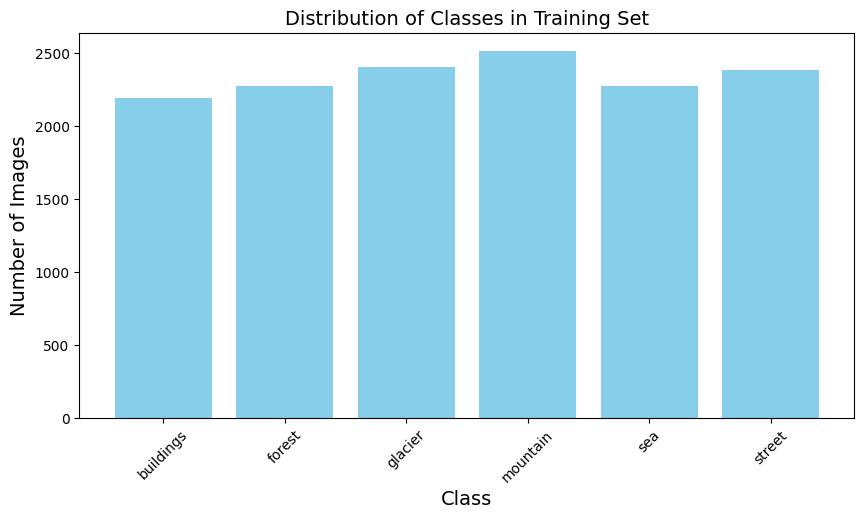

In [115]:
class_counts = {class_name: len(os.listdir(os.path.join(seg_train_dir, class_name))) for class_name in class_names}

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Set')
plt.xticks(rotation=45)
plt.show()

# Visualize a few examples

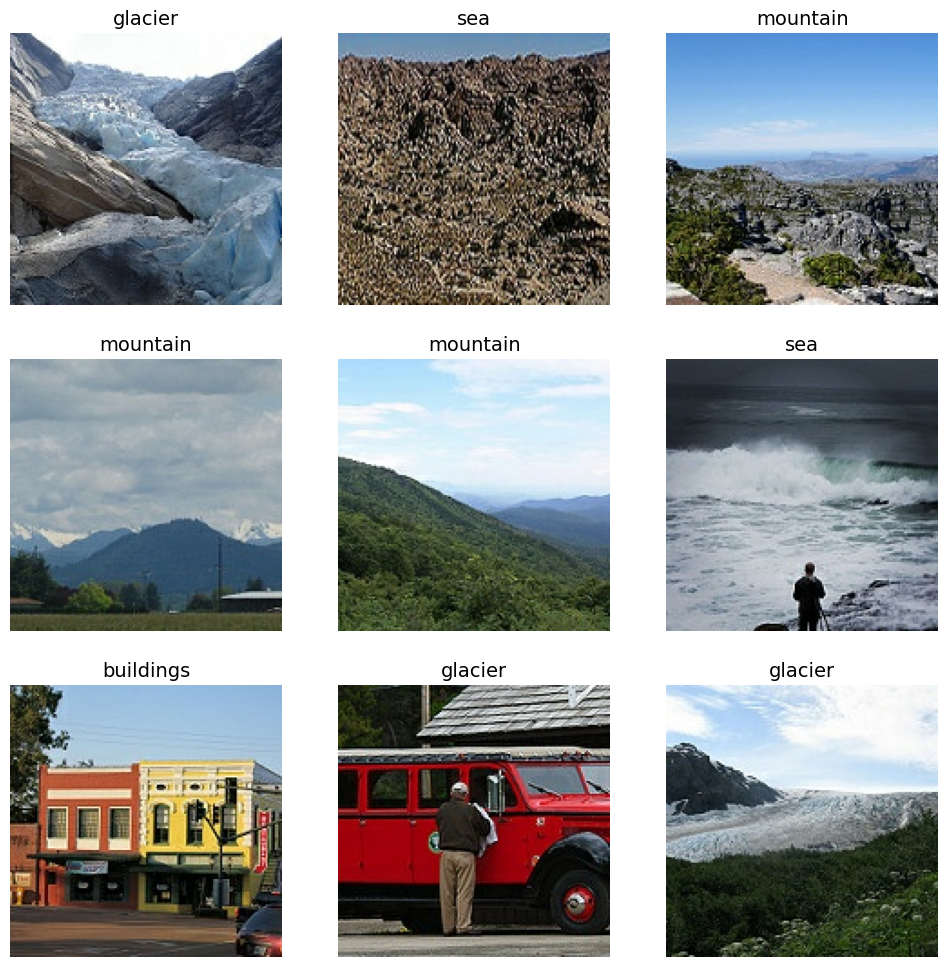

In [116]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()/255.)
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Data Augmentation


In [117]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(factor=0.3),
    layers.RandomShear(0.2),
    layers.RandomZoom(0.2),
])

# Visualize examples of augmented images


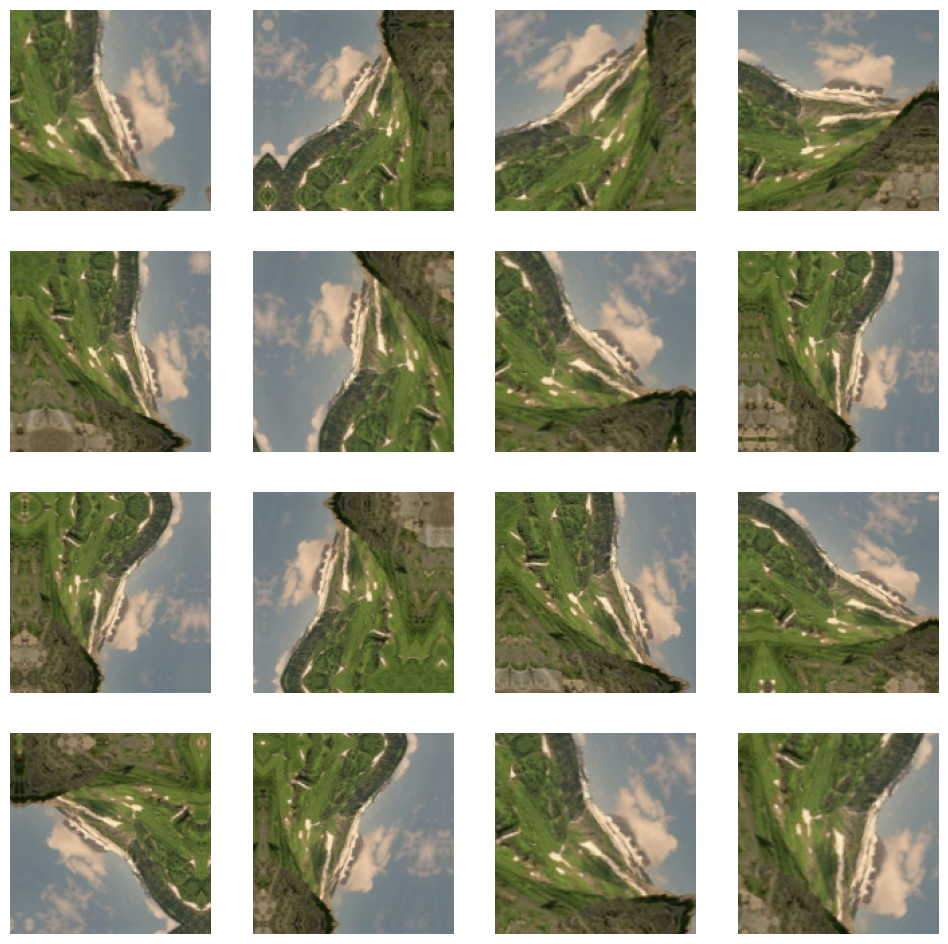

In [118]:
plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy()/255.)
    plt.axis("off")

# Creation of a baseline CNN




In [82]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
a = layers.Rescaling(scale = 1./255)(inputs)
a = data_augmentation(a)

a = layers.Conv2D(64, 3, activation='relu', padding='same') (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(64, 3, activation='relu', padding='same') (a)

a = layers.Flatten() (a)
a = layers.Dense(64, activation='relu') (a)

outputs = keras.layers.Dense(6, activation="softmax") (a)

model_baseline_CCN = keras.Model(inputs=inputs, outputs=outputs)

# Check the limit for the maximum number of parameters

In [53]:
model_baseline_CCN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 360000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    23,040,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,079,174 (88.04 MB)

 Trainable params: 23,079,174 (88.04 MB)

 Non-trainable params: 0 (0.00 B)

# Model compilation

In [54]:
model_baseline_CCN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train for 20 epochs

In [55]:
history = model_baseline_CCN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3621 - loss: 1.8974 - val_accuracy: 0.4838 - val_loss: 1.3697
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.5113 - loss: 1.2131 - val_accuracy: 0.4967 - val_loss: 1.3961
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.5519 - loss: 1.1389 - val_accuracy: 0.5330 - val_loss: 1.2467
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.5804 - loss: 1.0977 - val_accuracy: 0.5508 - val_loss: 1.1609
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.5893 - loss: 1.0746 - val_accuracy: 0.5677 - val_loss: 1.1614
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.5970 - loss: 1.0584 - val_accuracy: 0.5810 - val_loss: 1.0739
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.6129 - loss: 1.0187 - val_accuracy: 0.5862 - val_loss: 1.0948
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.6232 - loss: 1.0014 - 

# Visualize results (both accuracy and loss)

In [1]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

NameError: name 'pd' is not defined

# Creation of a Model 2 CNN

In [119]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
a = layers.Rescaling(scale = 1./255)(inputs)
a = data_augmentation(a)

a = layers.Conv2D(128, 3, activation='relu', padding='same') (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(128, 3, activation='relu', padding='same') (a)

a = layers.Flatten() (a)
a = layers.Dense(128, activation='relu') (a)

outputs = keras.layers.Dense(6, activation="softmax") (a)

model2_CNN = keras.Model(inputs=inputs, outputs=outputs)


In [120]:
model2_CNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 720000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    92,160,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,312,070 (352.14 MB)

 Trainable params: 92,312,070 (352.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.3368 - loss: 3.0247 - val_accuracy: 0.4867 - val_loss: 1.3618
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - accuracy: 0.4849 - loss: 1.2770 - val_accuracy: 0.5397 - val_loss: 1.1930
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 34s 111ms/step - accuracy: 0.5227 - loss: 1.1958 - val_accuracy: 0.5639 - val_loss: 1.1437
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 34s 111ms/step - accuracy: 0.5430 - loss: 1.1698 - val_accuracy: 0.5584 - val_loss: 1.1484
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.5516 - loss: 1.1425 - val_accuracy: 0.5508 - val_loss: 1.1711
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.5575 - loss: 1.1224 - val_accuracy: 0.5895 - val_loss: 1.0902
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 34s 111ms/step - accuracy: 0.5854 - loss: 1.0883 - val_accuracy: 0.5957 - val_loss: 1.0409
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.5961 - loss: 1

<Axes: >

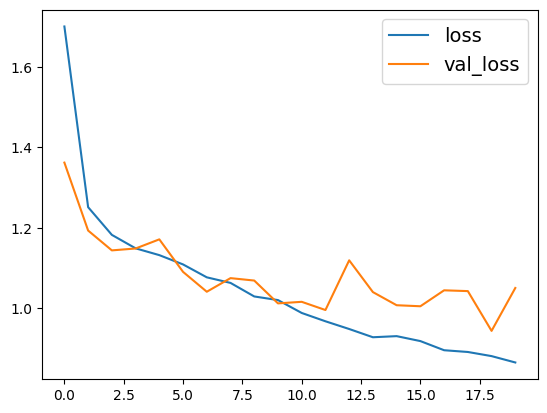

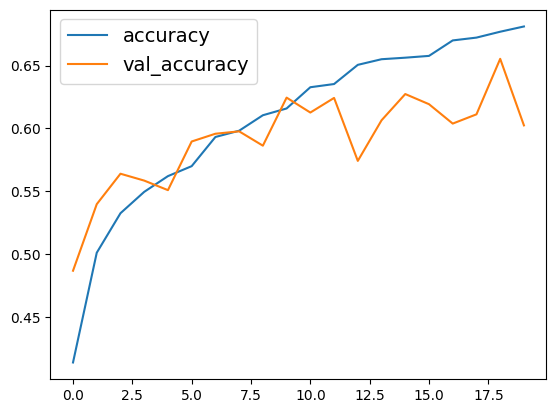

In [121]:
model2_CNN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history2_CNN = model2_CNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

history_frame = pd.DataFrame(history2_CNN.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Creation of a Model 3 CNN

In [122]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
a = layers.Rescaling(scale = 1./255)(inputs)
a = data_augmentation(a)

a = layers.Conv2D(256, 3, activation='relu', padding='same') (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(128, 3, activation='relu', padding='same') (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(64, 3, activation='relu', padding='same') (a)

a = layers.Flatten() (a)
a = layers.Dense(128, activation='relu') (a)
a = layers.Dropout(0.5) (a)
a = layers.Dense(64, activation='relu') (a)

outputs = keras.layers.Dense(6, activation="softmax") (a)

model3_CNN = keras.Model(inputs=inputs, outputs=outputs)

In [123]:
model3_CNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,599,622 (44.25 MB)

 Trainable params: 11,599,622 (44.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 37s 111ms/step - accuracy: 0.3148 - loss: 1.5854 - val_accuracy: 0.4133 - val_loss: 1.3179
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.4174 - loss: 1.3532 - val_accuracy: 0.5173 - val_loss: 1.2012
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.4761 - loss: 1.2768 - val_accuracy: 0.4575 - val_loss: 1.3111
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.4975 - loss: 1.2370 - val_accuracy: 0.5428 - val_loss: 1.1373
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.5182 - loss: 1.1932 - val_accuracy: 0.4646 - val_loss: 1.2655
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.5375 - loss: 1.1640 - val_accuracy: 0.5385 - val_loss: 1.1528
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.5469 - loss: 1.1244 - val_accuracy: 0.5713 - val_loss: 1.0972
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.5669 - loss: 1

<Axes: >

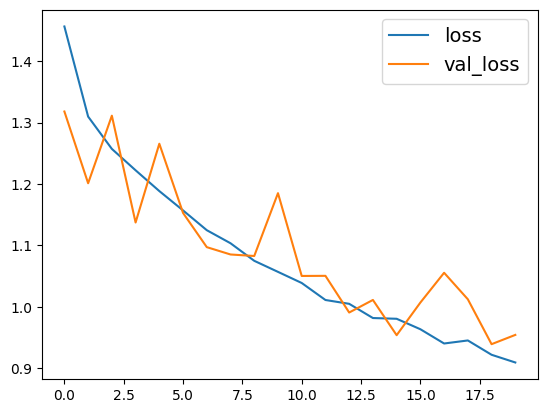

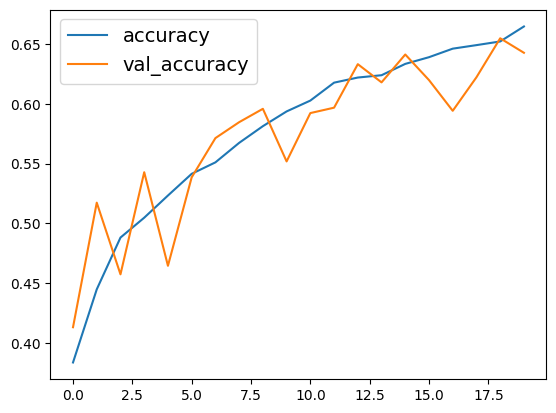

In [124]:
model3_CNN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history3_CNN = model3_CNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

history_frame = pd.DataFrame(history3_CNN.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Creation of a Model 4 CNN

In [125]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
a = layers.Rescaling(scale = 1./255)(inputs)
a = data_augmentation(a)

a = layers.Conv2D(512, 3, activation='relu', padding='same') (a)
a = layers.BatchNormalization() (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(256, 3, activation='relu', padding='same') (a)
a = layers.BatchNormalization() (a)

a = layers.Conv2D(128, 3, activation='relu', padding='same') (a)
a = layers.BatchNormalization() (a)

a = layers.Conv2D(64, 3, activation='relu', padding='same') (a)
a = layers.BatchNormalization() (a)

a = layers.Flatten() (a)
a = layers.Dense(256, activation='relu') (a)
a = layers.Dropout(0.5) (a)
a = layers.Dense(128, activation='relu') (a)
a = layers.Dense(64, activation='relu') (a)

outputs = keras.layers.Dense(6, activation="softmax") (a)

model4_CNN = keras.Model(inputs=inputs, outputs=outputs)

In [126]:
model4_CNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 512)  │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 512)  │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 360000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    92,160,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,768,710 (357.70 MB)

 Trainable params: 93,766,790 (357.69 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [127]:
model4_CNN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history4_CNN = model4_CNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

history_frame = pd.DataFrame(history4_CNN.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/functional_1/batch_normalization_1/moments/sub defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-127-8852070cfb1a>", line 3, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 77, in train_step

failed to allocate memory
	 [[{{node gradient_tape/functional_1/batch_normalization_1/moments/sub}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_939295]

# Creation of a Model 5 CNN


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
a = layers.Rescaling(scale = 1./255)(inputs)
a = data_augmentation(a)

a = layers.Conv2D(32, 3, activation='relu', padding='same') (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(32, 3, activation='relu', padding='same') (a)

a = layers.Flatten() (a)
a = layers.Dense(32, activation='relu') (a)

outputs = keras.layers.Dense(6, activation="softmax") (a)

model5_CNN = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model5_CNN.summary()

In [ ]:
model5_CNN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history5_CNN = model5_CNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

history_frame = pd.DataFrame(history5_CNN.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()